# Volume 3: Gibbs Sampling and LDA
    Benj McMullin
    Math 405 
    1/30/2024

In [2]:
import numpy as np
from scipy.special import gammaln
from scipy.stats import norm, invgamma, gaussian_kde
from math import sqrt
from matplotlib import pyplot as plt

## Problem 1

Write a function that accepts data $y$, prior parameters $\nu$, $\tau^2$, $\alpha$, and $\beta$, and an integer $n$. Use Gibbs sampling to generate $n$ samples of $\mu$ and $\sigma^2$ for the data in `examscores.npy`.

Test your sampler with priors $\nu=80$, $\tau^{2} = 16$, $\alpha = 3$, and $\beta = 50$, collecting $1000$ samples.
Plot your samples of $\mu$ and your samples of $\sigma^{2}$ versus the number of samples.

In [3]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """ Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.
        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Parameters:
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    # Initialize prior
    mu = norm.rvs(nu, scale=sqrt(tau2))
    sigma2 = invgamma.rvs(alpha, scale=beta)

    N = len(y)
    samples = np.empty((n_samples, 2))

    # Iterate through number of samples
    for k in range(n_samples):
        # Update mu and sigma2 using Gibbs sampling
        sig_star2 = 1 / (1 / tau2 + N / sigma2)
        mu_star = sig_star2 * (nu / tau2 + (1 / sigma2) * np.sum(y))
        alpha_star = alpha + (N / 2)
        beta_star = beta + 0.5 * np.sum([(yi - mu) ** 2 for yi in y])

        # Sample mu from its conditional distribution
        mu = norm.rvs(mu_star, scale=sqrt(sig_star2))

        # Sample sigma2 from its conditional distribution
        sigma2 = invgamma.rvs(alpha_star, scale=beta_star)

        # Save samples
        samples[k, 0] = mu
        samples[k, 1] = sigma2

    return samples

In [4]:
# Load data and set parameters
y = np.load("examscores.npy")
nu = 80
tau2 = 16
alpha = 3
beta = 50
n_samples = 1000

# Run Gibbs sampler and plot results
samples = gibbs(y, nu, tau2, alpha, beta, n_samples)

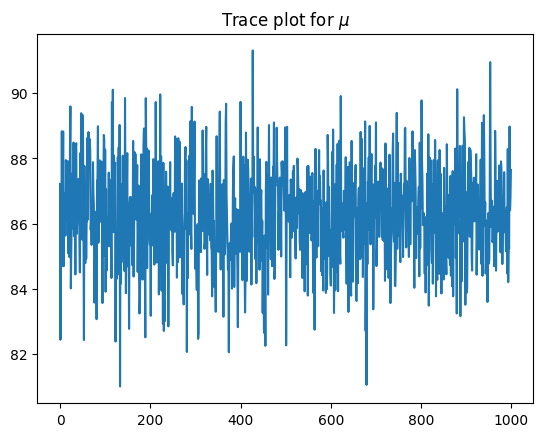

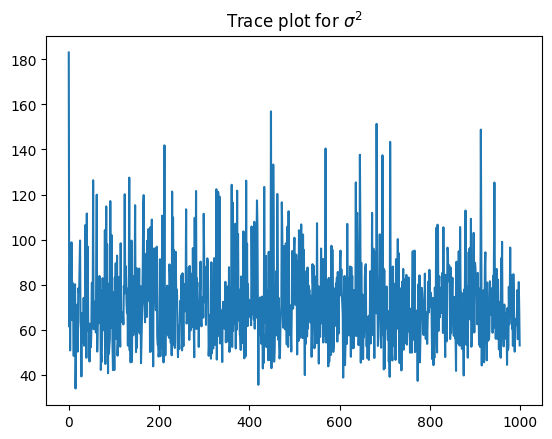

In [7]:
# Plot the marginal posterior distributions
plt.plot(samples[:, 0])
plt.title(r"Trace plot for $\mu$")
plt.show()

plt.plot(samples[:, 1])
plt.title(r"Trace plot for $\sigma^2$")
plt.show()

## Problem 2

Plot the kernel density estimators for the posterior distributions of $\mu$ and $\sigma^2$.

Next, use your samples of $\mu$ and $\sigma^2$ to draw samples from the posterior predictive distribution.
Plot the kernel density estimator of your sampled scores.

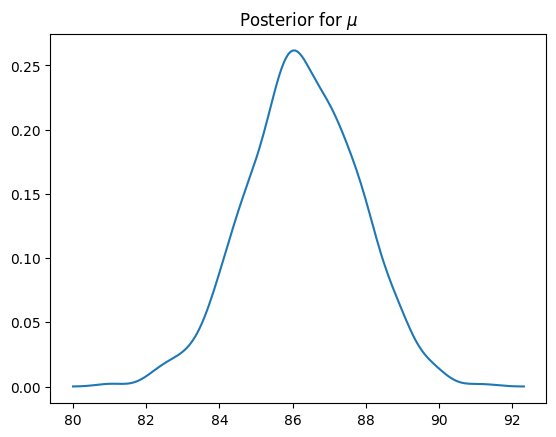

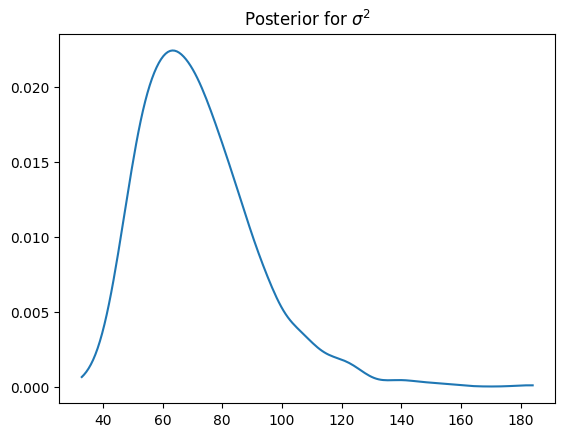

In [8]:
# Plot the marginal posterior distributions
mu_kernal = gaussian_kde(samples[:, 0])
x = np.linspace(min(samples[:, 0]) - 1, max(samples[:, 0]) + 1, 200)
plt.plot(x, mu_kernal(x))
plt.title(r"Posterior for $\mu$")
plt.show()

# Plot the marginal posterior distributions
sig_kernal = gaussian_kde(samples[:, 1])
x = np.linspace(min(samples[:, 1]) - 1, max(samples[:, 1]) + 1, 200)
plt.plot(x, sig_kernal(x))
plt.title(r"Posterior for $\sigma^2$")
plt.show()

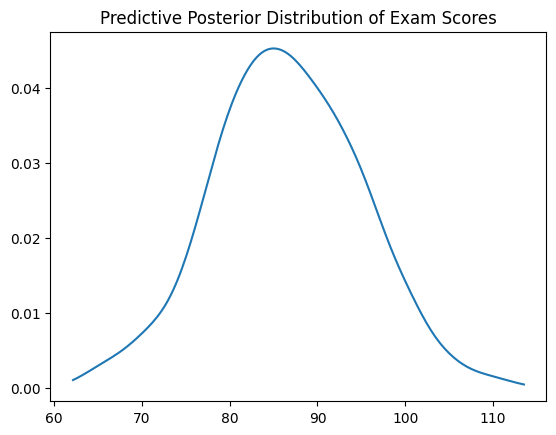

In [9]:
# Generate new samples from the predictive posterior distribution
new_samples = norm.rvs(samples[:, 0], scale = np.sqrt(samples[:, 1]))

# Plot the predictive posterior distribution
new_samples_kernal = gaussian_kde(new_samples)
x = np.linspace(min(new_samples) - 1, max(new_samples) + 1, 200)
plt.plot(x, new_samples_kernal(x))
plt.title("Predictive Posterior Distribution of Exam Scores")
plt.show()

## Problem 3

Complete the method `LDACGS._initialize()`.



## Problem 4

Complete the method `LDACGS._sweep()`.



## Problem 5

Complete the method `LDACGS.sample()`.


In [10]:
class LDACGS:
    """ Do LDA with Gibbs Sampling. """

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """ Initializes attributes n_topics, alpha, and beta. """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def _buildCorpus(self, filename, stopwords_file=None):
        """ Reads the given filename, and using any provided stopwords,
            initializes attributes vocab and documents. In this lab,
            each line of filename is considered a document.
            
            vocab is a list of terms found in filename.
            
            documents is a list of dictionaries (a dictionary for each 
            document); for dictionary m in documents, each entry is of 
            the form n:v, where v is the index in vocab of the nth word 
            in document m.
        """
        with open(filename, 'r') as infile:  # Create vocab
            doclines = [line.rstrip().lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})

        self.docs = doclines  # Save the documents for toplines()

        if stopwords_file:   # If there are stopwords, remove them from vocab
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        
        self.documents = []  # Create documents
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])


    def _initialize(self):
        """ Initializes attributes n_words, n_docs, the three count matrices, 
            and the topic assignment dictionary topics.
                        
            Note that
            n_topics = K, the number of possible topics
            n_docs   = M, the number of documents being analyzed
            n_words  = V, the number of words in the vocabulary
            
            To do this, you will need to initialize nkm, nkv, and nk 
            to be zero arrays of the correct size.
            Matrix nkm corresponds to n_(k,m,.)
            Matrix nkv corresponds to n_(k,.,v)
            Matrix nk corresponds to n_(k,.,.)
            You will then iterate through each word found in each document.
            In the second of these for-loops (for each word), you will 
            randomly assign k as an integer from the correct range of topics.
            Then, you will increment each of the count matrices by 1, 
            given the values for k, m, and v, where v is the index in 
            vocab of the nth word in document m.
            Finally, assign topics as given.
        """
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
                
        # Initialize the three count matrices
        # The (k, m) entry of self.nkm is the number of words in document m assigned to topic k
        self.nkm = np.zeros((self.n_topics, self.n_docs))
        # The (k, v) entry of self.nkv is the number of times term v is assigned to topic k
        self.nkv = np.zeros((self.n_topics, self.n_words))
        # The (k)-th entry of self.nk is the number of times topic k is assigned in the corpus
        self.nk = np.zeros(self.n_topics)
        
        # Initialize the topic assignment dictionary
        self.topics = {} # Key-value pairs of form (m,n):k
        
        random_distribution = np.ones(self.n_topics) / self.n_topics
        for m in range(self.n_docs):
            for n in self.documents[m]:
                # Get random topic assignment, i.e. k = ...
                # Increment count matrices
                # Store topic assignment, i.e. self.topics[(m,n)]=k
                # Get random topic assignment, i.e. z = ...
                z = np.random.randint(1, self.n_topics)
                # Increment count matrices
                self.nkm[z, m] += 1
                w = self.documents[m][n]
                self.nkv[z, w] += 1
                self.nk[z] += 1
                
                # Store topic assignment 
                self.topics[(m,n)] = z
                
                
    def _sweep(self):
        """ Iterates through each word of each document, giving a better
            topic assignment for each word.
            
            To do this, iterate through each word of each document. 
            The first part of this method will undo what _initialize() did
            by decrementing each of the count matrices by 1.
            Then, call the method _conditional() to use the conditional 
            distribution (instead of the uniform distribution used 
            previously) to pick a more accurate topic assignment k.
            Finally, repeat what _initialize() did by incrementing each of
            the count matrices by 1, but this time using the more 
            accurate topic assignment.
        """
        for m in range(self.n_docs):
            for n in self.documents[m]:
                # Retrieve vocab index for n-th word in document m
                # Retrieve topic assignment for n-th word in document m
                # Decrement count matrices
                # Get conditional distribution
                # Sample new topic assignment
                # Increment count matrices
                # Store new topic assignment
                # Retrieve vocab index for i-th word in document m.
                w = self.documents[m][n]
                
                # Retrieve topic assignment for i-th word in document m.
                z = self.topics[(m, n)]
                
                # Decrement count matrices.
                self.nkm[z, m] -= 1
                self.nkv[z, w] -= 1
                self.nk[z] -= 1
                
                # Get conditional distribution.
                cond = self._conditional(m, w)
                                      
                # Sample new topic assignment.
                z = np.argmax(np.random.binomial(1, cond))
                                      
                # Increment count matrices.
                self.nkm[z, m] += 1
                self.nkv[z, w] += 1
                self.nk[z] += 1
                                      
                # Store new topic assignment.
                self.topics[(m, n)] = z

                
    def sample(self, filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        """ Runs the Gibbs sampler on the given filename. 
        
            The argument filename is the name and location of a .txt 
            file, which can be read in by the provided method _buildCorpus()
            to build the corpus. Stopwords are removed if the stopwords
            argument is provided. Note that in buildCorpus(),
            each line of filename is considered a document.
            
            Initialize attributes total_nkm, total_nkv, and logprobs as
            zero arrays.
            total_nkm and total_nkv will be the sums of every 
            sample_rate-th nkm and nkv matrix respectively.
            logprobs is of length burnin + sample_rate * n_samples
            and will store each log-likelihood after each sweep of 
            the sampler.
            
            Burn-in the Gibbs sampler. After the burn-in, iterate further 
            for n_samples iterations, adding nkm and nkv to total_nkm and 
            total_nkv respectively, at every sample_rate-th iteration.
            Also, compute and save the log-likelihood at each iteration 
            in logprobs using the method _loglikelihood().
        """
        self._buildCorpus(filename, stopwords_file)
        self._initialize()
        
        self.total_nkm = np.zeros((self.n_topics, self.n_docs))
        self.total_nkv = np.zeros((self.n_topics, self.n_words))
        self.logprobs = np.zeros(burnin + sample_rate * n_samples)
        
        for i in range(burnin):
            # Sweep and store log likelihood.
            self._sweep()
            self.logprobs[i] = self._loglikelihood()

        for i in range(sample_rate * n_samples):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[burnin + i] = self._loglikelihood()
            
            # If at sample iteration, accumulate counts
            if not i % sample_rate:
                # accumulate counts
                self.total_nkv += np.copy(self.nkv)
                self.total_nkm += np.copy(self.nkm)

                
    def _conditional(self, m, v):
        """ Returns the conditional distribution given m and w.
            Called by _sweep(). """
        dist = (self.nkm[:,m] + self.alpha) * (self.nkv[:,v] + self.beta) / (self.nk + self.beta * self.n_words)
        return dist / np.sum(dist)

    def _loglikelihood(self):
        """ Computes and returns the log-likelihood. Called by sample(). """
        lik = 0

        for k in range(self.n_topics):
            lik += np.sum(gammaln(self.nkv[k,:] + self.beta)) - gammaln(np.sum(self.nkv[k,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words * self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nkm[:,m] + self.alpha)) - gammaln(np.sum(self.nkm[:,m] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics * self.alpha)

        return lik
    
    def _phi(self):
        """ Initializes attribute phi. Called by topterms(). """
        phi = self.total_nkv + self.beta
        self.phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def _theta(self):
        """ Initializes attribute theta. Called by toplines(). """
        theta = self.total_nkm + self.alpha
        self.theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self, n_terms=10):
        """ Returns the top n_terms of each topic found. """
        self._phi()
        vec = np.atleast_2d(np.arange(0, self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self.phi[k,:])
            mat = np.append(probs, vec, 0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1, self.n_words - 1 - i])] 
                           for i in range(n_terms)])
        return topics

    def toplines(self, n_lines=5):
        """ Print the top n_lines corresponding to each topic found. """
        self._theta()
        lines = np.zeros((self.n_topics,n_lines))
        for k in range(self.n_topics):
            args = np.argsort(self.theta[:,k]).tolist()
            args.reverse()
            lines[k,:] = np.array(args)[0:n_lines] + 1
        lines = lines.astype(int)

        for k in range(self.n_topics):
            print(f"TOPIC {k + 1}")
            for document in lines[k]:
                print(" ".join(self.docs[document]))

## Problem 6

Create an `LDACGS` object with 20 topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn-in of 100 iterations, accumulating 10 samples, only keeping the results of every 10th sweep.
Use `stopwords.txt` as the stopwords file.

Plot the log-likelihoods. How many iterations did it take to burn-in?

In [12]:
# Test the LDA Gibbs sampler on the Reagan.txt file
ldagibbs = LDACGS(20)
file = "reagan.txt"
stop = "stopwords.txt"
ldagibbs.sample(file, stopwords_file = stop)

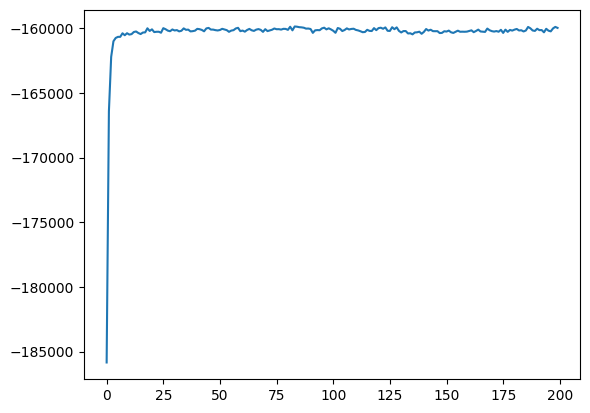

In [13]:
# Plot it
plt.plot(ldagibbs.logprobs)
plt.show()

## Problem 7

Using the method `LDACGS.topterms()`, examine the topics for Reagan's addresses. 

If `n_topics=20` and `n_samples=10`, you should get the top $10$ words that represent each of the $20$ topics.

Print out all $20$ topics with the associated top $10$ words. For the top $5$ topics, decide what their top $10$ words jointly represent, and come up with a label for them.

In [14]:
print(ldagibbs.topterms())

[['--', 'government', 'people', 'american', 'federal', 'america', 'tax', 'economic', 'years', "we're"], ['.', 'night', 'setting', 'rising', 'music', 'sun', 'heroism', 'weighing', 'days,', 'born'], ['address', 'president', 'session', 'joint', 'ronald', 'congress', "reagan's", 'union', 'state', 'wounded'], ['thousand-dollar', '"h."', 'stack', '"honorable"', 'trillion', 'realistic', 'inches', 'demand.', 'unborn', 'deny'], ['apiece.', 'movement', 'rule', 'class.', 'opening', 'another,', 'girl', 'learned', 'graduate', 'greatly'], ['paralyzed', 'vehicles', 'needlessly', 'original', '45', 'figure', 'write-off', 'york', 'elderly', 'dissolution,'], ['mr.', 'speaker,', 'congress,', 'members', 'president,', 'distinguished', 'fellow', 'honored', 'citizens:', 'guests,'], ['sandinista', 'communist', 'hungry', 'hospital', 'major,', 'choking', 'roger', 'feeding', 'miranda,', 'paralyzed'], ['apiece.', 'arctic', 'line.', 'wounds,', 'couples,', 'produced', 'soothe', 'birthplace', 'hospital', 'bond'], ['c

1.  goverment spending
2.  clubbing
3.  money
4.  abortion
5.  speeches
6.  rural life
7.  trains
8.  online terrorists
9.  heritage
10. tax deduction
11. Make America Great Again
12. weaponry
13. Unity
14. Sin
15. election
16. concrete
17. tax increase
18. school
19. work
20. ghosts